# Brain Tumour Segmentation with U-Net Variants and an Autoencoder

This notebook investigates 2D brain tumour segmentation on the BraTS 2020 training data using several architectures:


*   A baseline U-Net.
*   A modernized U-Net with separable convolutions and residual-style tweaks.
*   An attention U-Net that applies attention over skip connections.
*   A convolutional autoencoder for unsupervised representation learning.

All models are implemented in TensorFlow/Keras and trained on 2D slices stored in `.h5` files.


## Dataset and Problem Definition

The dataset is based on the BraTS 2020 brain tumour collection, stored as `.h5` files where each file contains:

- `image`: MRI slice of shape `(240, 240, 4)`, dtype `float64`.
- `mask`: tumour segmentation of shape `(240, 240, 3)`, dtype `uint8`.

Each slice corresponds to a single axial 2D slice of a 3D volume.

**Image channels (4):**

1. T1-weighted (T1): high-resolution anatomical image.
2. T1 post-contrast (T1c / T1Gd): highlights contrast-enhancing tumour regions.
3. T2-weighted (T2): sensitive to fluid and edema.
4. FLAIR: suppresses CSF signal and emphasizes peritumoral edema.

**Mask channels (3):**

1. Necrotic / Non-enhancing tumour core (NCR/NET).
2. Edema (ED).
3. Enhancing tumour (ET).

The task is **multi-label semantic segmentation** at the slice level: predict a 3-channel binary mask from a 4-channel MRI slice.


In [ ]:
!pip install nibabel --quiet

import os
import glob
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import h5py
from tensorflow import keras
print("TF version:", tf.__version__)


TF version: 2.19.0


In [ ]:
# import zipfile

# zip_path = "/content/drive/MyDrive/Data/Brats/brats.zip"
# extract_dir = "/content/drive/MyDrive/Data/Brats/"

# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, "r") as zf:
#     zf.extractall(extract_dir)

# print("Done, extracted to:", extract_dir)

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data"

def list_h5_files(data_dir=DATA_DIR):
    files = sorted(
        [f for f in os.listdir(data_dir) if f.endswith(".h5")]
    )
    return files

h5_files = list_h5_files()
len(h5_files), h5_files[:5]

(44655,
 ['volume_100_slice_0.h5',
  'volume_100_slice_1.h5',
  'volume_100_slice_10.h5',
  'volume_100_slice_100.h5',
  'volume_100_slice_101.h5'])

In [ ]:
# Code cell: define data dir and list files

DATA_DIR = "/content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data"

all_h5_files = sorted(
    [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".h5")]
)
len(all_h5_files), all_h5_files[:3]


(44655,
 ['/content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data/volume_100_slice_0.h5',
  '/content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data/volume_100_slice_1.h5',
  '/content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data/volume_100_slice_10.h5'])

In [ ]:
# Code cell: inspect one file

sample_path = random.choice(all_h5_files)
print("Sample file:", os.path.basename(sample_path))

with h5py.File(sample_path, "r") as f:
    image = f["image"][()]  # (240, 240, 4)
    mask  = f["mask"][()]   # (240, 240, 3)
    print("image shape:", image.shape, "dtype:", image.dtype,
          "min:", image.min(), "max:", image.max())
    print("mask shape :", mask.shape,  "dtype:", mask.dtype,
          "unique mask values:", np.unique(mask))


Sample file: volume_309_slice_127.h5
image shape: (240, 240, 4) dtype: float64 min: -0.28595733610025403 max: 8.073563311255597
mask shape : (240, 240, 3) dtype: uint8 unique mask values: [0]


## Exploratory Data Analysis (EDA)

This section inspects a subset of slices to understand data characteristics:

- Visualisation of individual MRI channels (T1, T1c, T2, FLAIR) with `imshow`.
- Visualisation of each mask channel as pseudo-RGB overlays.
- Overlay of tumour masks on the anatomical T1 or FLAIR channel.

The goals are:

- To confirm intensity ranges and normalisation needs.
- To inspect typical tumour shapes, locations, and class imbalance.
- To verify that channel order and mask encoding are consistent across files.


In [ ]:
# Code cell: helper plotting functions

plt.style.use("ggplot")

channel_names = [
    "T1-weighted (T1)",
    "T1 post-contrast (T1c)",
    "T2-weighted (T2)",
    "FLAIR"
]

mask_channel_names = [
    "Necrotic / Non-enhancing core (NCR/NET)",
    "Edema (ED)",
    "Enhancing tumour (ET)"
]

def show_image_channels(image_2d):
    """image_2d: (240,240,4), float or int."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(image_2d[..., i], cmap="gray")
        ax.set_title(channel_names[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


def show_mask_channels(mask_2d):
    """mask_2d: (240,240,3), binary channels."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axes):
        rgb = np.zeros((*mask_2d.shape[:2], 3), dtype=np.uint8)
        rgb[..., i] = (mask_2d[..., i] * 255).astype(np.uint8)
        ax.imshow(rgb)
        ax.set_title(mask_channel_names[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


def overlay_mask(image_2d, mask_2d, alpha=0.4):
    """Overlay 3-channel mask as RGB on a single MRI channel (e.g. FLAIR)."""
    # Choose FLAIR as background (channel index 3)
    base = image_2d[..., 3]
    base_norm = (base - base.min()) / (base.max() - base.min() + 1e-6)

    rgb_base = np.stack([base_norm]*3, axis=-1)
    rgb_mask = np.zeros_like(rgb_base)
    rgb_mask[..., 0] = mask_2d[..., 2]  # ET -> red
    rgb_mask[..., 1] = mask_2d[..., 1]  # ED -> green
    rgb_mask[..., 2] = mask_2d[..., 0]  # NCR/NET -> blue

    overlay = (1 - alpha) * rgb_base + alpha * rgb_mask

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.title("FLAIR with tumour mask overlay")
    plt.axis("off")
    plt.show()


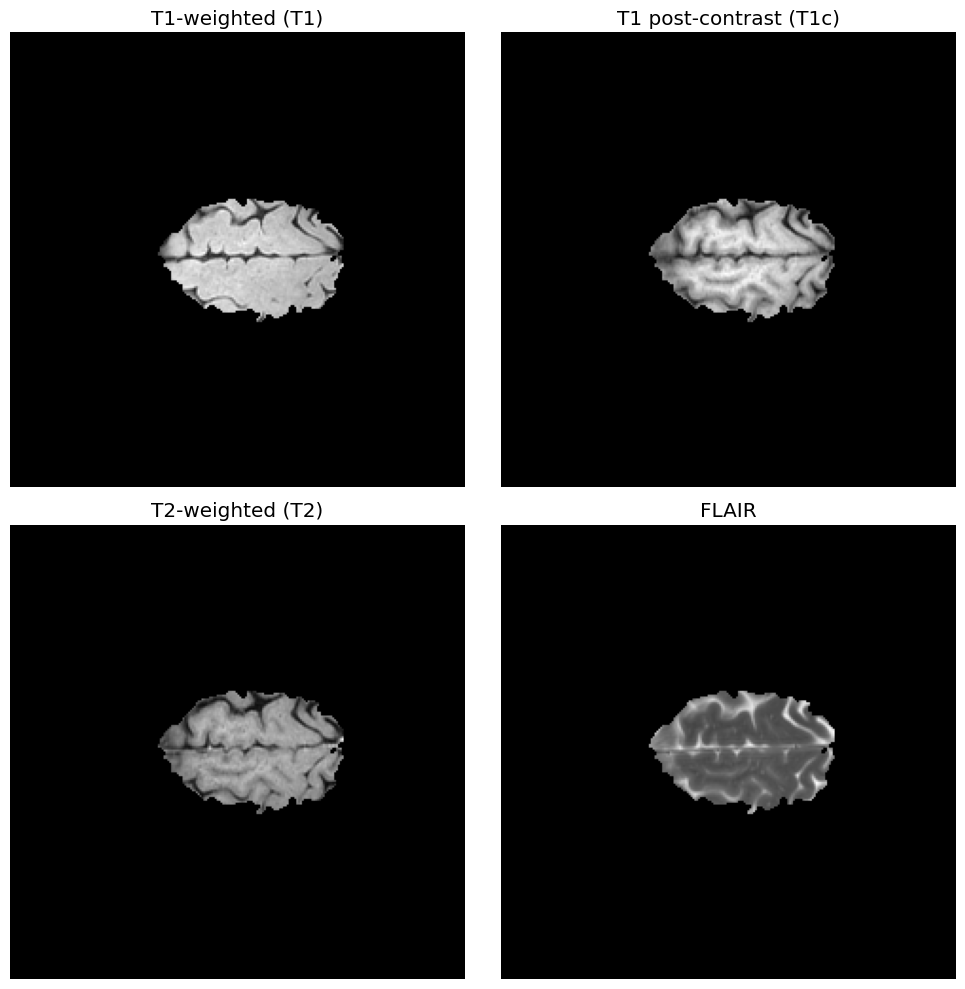

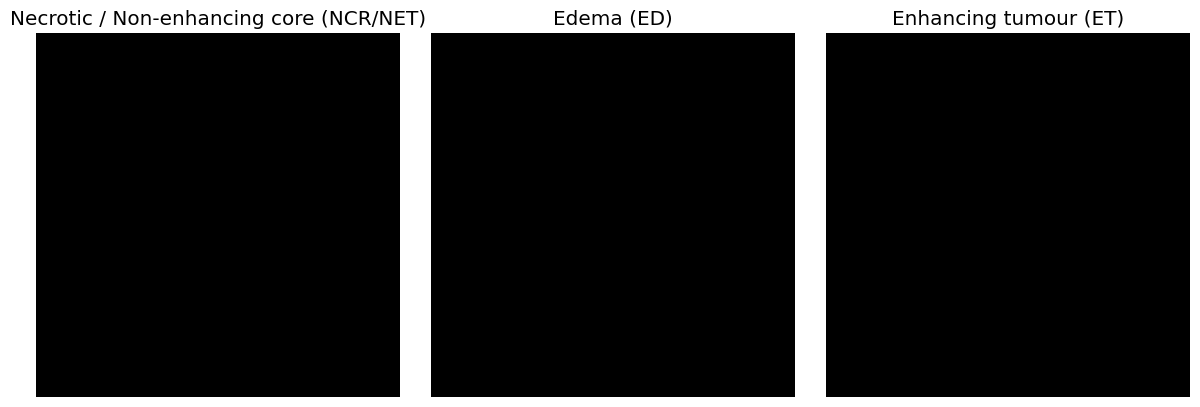

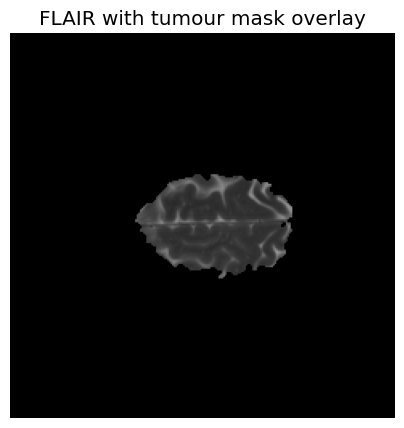

In [ ]:

# Code cell: EDA on one random slice

with h5py.File(sample_path, "r") as f:
    img = f["image"][()]
    msk = f["mask"][()]

show_image_channels(img)
show_mask_channels(msk)
overlay_mask(img, msk)


Picked a no tumor example. Thus all masks are clear.

In [ ]:
with h5py.File(sample_path, "r") as f:
    img = f["image"][()]
    msk = f["mask"][()]

print("image shape:", img.shape, "dtype:", img.dtype,
      "min:", img.min(), "max:", img.max())
print("mask shape :", msk.shape, "dtype:", msk.dtype)

for i in range(msk.shape[-1]):
    print(f"Mask channel {i} sum:", msk[..., i].sum())
print("Total mask sum:", msk.sum())
print("Mask unique values:", np.unique(msk))


image shape: (240, 240, 4) dtype: float64 min: -0.28595733610025403 max: 8.073563311255597
mask shape : (240, 240, 3) dtype: uint8
Mask channel 0 sum: 0
Mask channel 1 sum: 0
Mask channel 2 sum: 0
Total mask sum: 0
Mask unique values: [0]


Non-empty mask file: /content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data/volume_236_slice_86.h5
Mask sums per channel: [np.uint64(102), np.uint64(1669), np.uint64(706)]


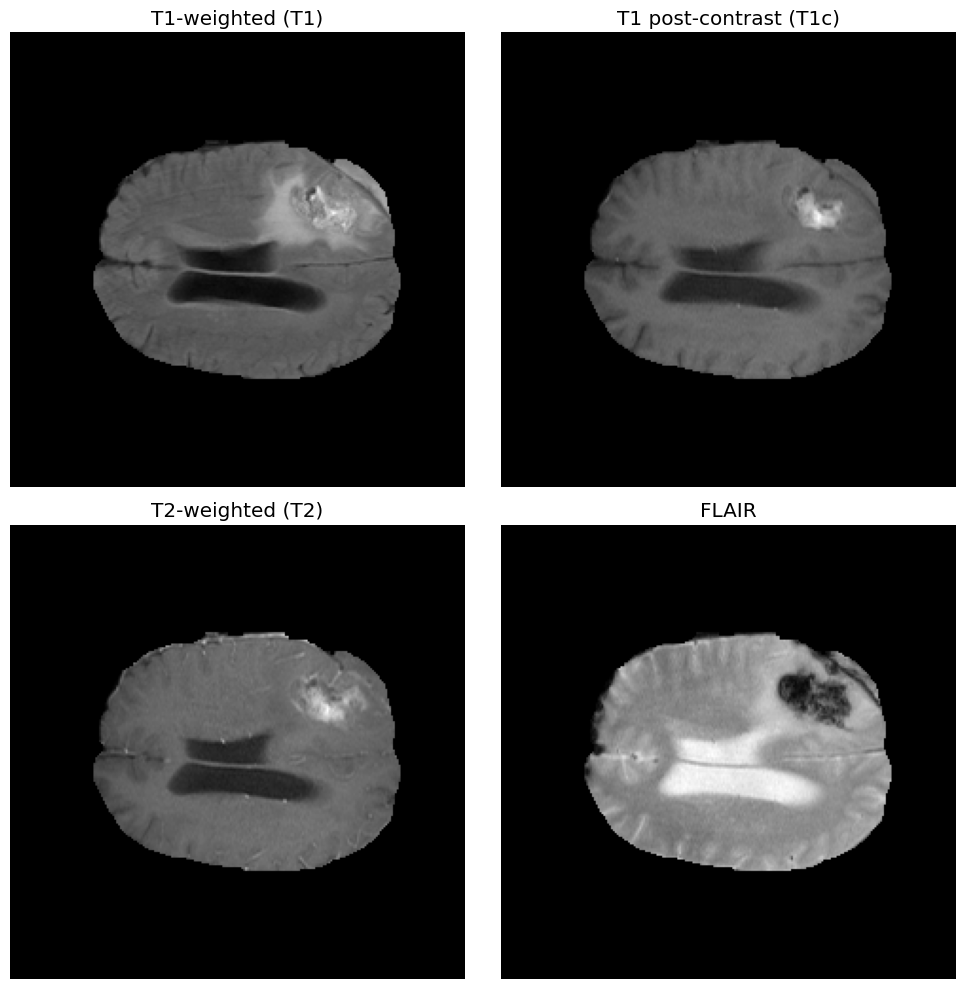

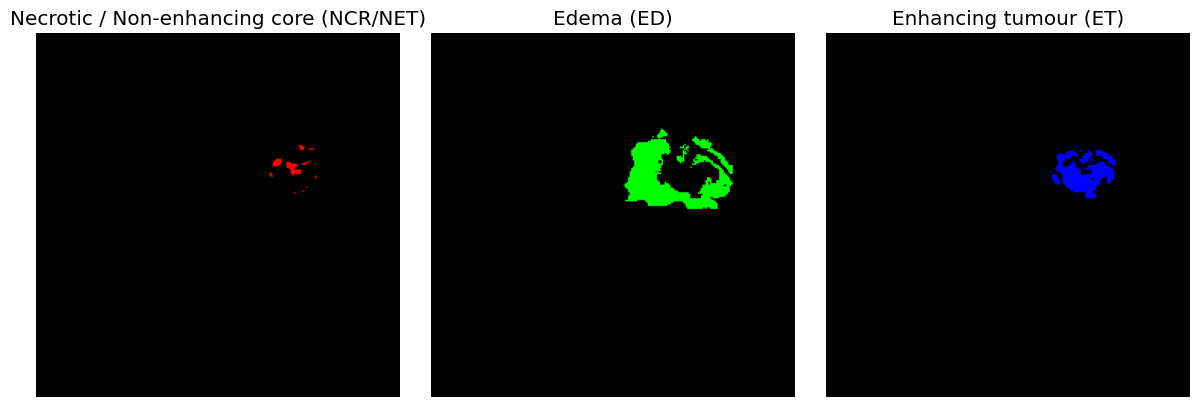

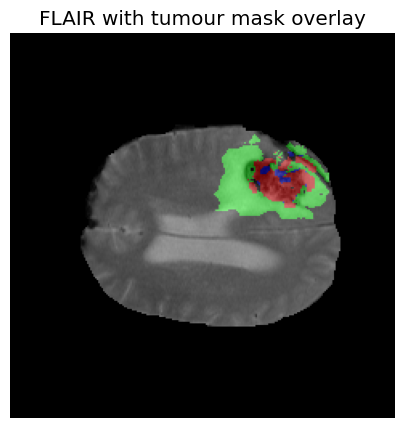

In [ ]:
def find_nonempty_mask_file(file_list, max_tries=300):
    # Shuffle to avoid always hitting the same few
    shuffled = file_list.copy()
    random.shuffle(shuffled)
    for path in shuffled[:max_tries]:
        with h5py.File(path, "r") as f:
            m = f["mask"][()]
        if m.sum() > 0:
            return path
    return None

sample_path = "/content/drive/MyDrive/Data/Brats/BraTS2020_training_data/content/data/volume_236_slice_86.h5" #a decent example found with code above
print("Non-empty mask file:", sample_path)

with h5py.File(sample_path, "r") as f:
    img = f["image"][()]
    msk = f["mask"][()]

print("Mask sums per channel:", [msk[..., i].sum() for i in range(msk.shape[-1])])

show_image_channels(img)
show_mask_channels(msk)
overlay_mask(img, msk)


## Data Loading and Preprocessing

Data is loaded from `.h5` files using a generator or `tf.data.Dataset` pipeline.

Key steps:

- Read `image` and `mask` arrays from HDF5.
- Transpose to channels-last format if needed: `(H, W, C)`.
- Per-channel normalisation of `image`:
  - Shift intensities so minimum is 0.
  - Scale each channel to `[0, 1]` by dividing by the maximum.
- Convert `mask` to `float32` in `{0, 1}` for each of the 3 tumour channels.
- Split file list into training and validation sets (e.g., 90/10 split).
- Build batched, shuffled `tf.data` pipelines with prefetching for efficient training.

The segmentation models consume batches of shape `(batch_size, 240, 240, 4)` and output logits of shape `(batch_size, 240, 240, 3)`.


In [ ]:
# Code cell: split train/val

MAX_SAMPLES = 50000
files = all_h5_files.copy()
random.shuffle(files)

if MAX_SAMPLES is not None:
    files = files[:MAX_SAMPLES]

split = int(0.9 * len(files))
train_files = files[:split]
val_files   = files[split:]

len(train_files), len(val_files)


(40189, 4466)

In [ ]:
# def load_h5_np(path_bytes):
#     """Load one slice from path (bytes) and normalise image channels to [0,1]."""
#     path = path_bytes.decode("utf-8")
#     with h5py.File(path, "r") as f:
#         image = f["image"][()]  # (240,240,4)
#         mask  = f["mask"][()]   # (240,240,3)

#     # Per-channel min-max normalisation to [0,1]
#     image = image.astype("float32")
#     for c in range(image.shape[-1]):
#         chan = image[..., c]
#         chan_min = chan.min()
#         chan = chan - chan_min
#         chan_max = chan.max() + 1e-6
#         chan = chan / chan_max
#         image[..., c] = chan

#     mask = mask.astype("float32")  # already 0/1
#     return image, mask
def load_h5_np(path_tensor):
    # path_tensor: tf.EagerTensor of dtype string
    path = path_tensor.numpy().decode("utf-8")
    with h5py.File(path, "r") as f:
        img = f["image"][()]  # (240, 240, 4)
        msk = f["mask"][()]   # (240, 240, 3)

    # any numpy preprocessing here...
    img = img.astype("float32")
    msk = msk.astype("float32")
    return img, msk


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SHAPE = (240, 240, 4)
MSK_SHAPE = (240, 240, 3)

def tf_load_h5(path):
    img, msk = tf.py_function(
        func=load_h5_np,
        inp=[path],
        Tout=[tf.float32, tf.float32],
    )
    # Set static shapes so Keras knows what to expect
    img.set_shape((240, 240, 4))
    msk.set_shape((240, 240, 3))
    return img, msk


def random_flip(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

BATCH_SIZE = 8

train_ds = (tf.data.Dataset.from_tensor_slices(train_files)
            .shuffle(buffer_size=len(train_files))
            .map(tf_load_h5, num_parallel_calls=AUTOTUNE)
            .map(random_flip, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices(val_files)
          .map(tf_load_h5, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))


In [ ]:
for batch_img, batch_msk in train_ds.take(1):
    print("Batch images:", batch_img.shape, "range:", float(tf.reduce_min(batch_img)), float(tf.reduce_max(batch_img)))
    print("Batch masks :", batch_msk.shape, "unique:", tf.unique(tf.reshape(batch_msk, [-1]))[0].numpy())


Batch images: (8, 240, 240, 4) range: -0.6162942051887512 19.997865676879883
Batch masks : (8, 240, 240, 3) unique: [0. 1.]



## 4. Loss and metrics

Segmentation objective:
 - Binary cross entropy (per pixel, per channel).
 - Global Dice coefficient as soft overlap measure.

Loss = BCE + (1 − Dice).


In [ ]:
# Code cell: Dice and BCE+Dice loss

def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Global multi-channel Dice over batch.
    Assumes y_pred are probabilities in [0,1].
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reduce_mean(bce)
    dice_loss = 1.0 - dice_coef(y_true, y_pred)
    return bce + dice_loss



## 5. Baseline U-Net
Architecture:
- Encoder: 4 blocks, each with two 3×3 conv layers + ReLU, then 2×2 max pooling.
- Bottleneck: two 3×3 conv layers at deepest resolution.
- Decoder: bilinear upsampling + concatenation with skip features + two conv layers.
- Output: 1×1 conv to 3 channels + sigmoid.

This model follows the standard U-Net pattern with channel depths:
32 → 64 → 128 → 256 → bottleneck(512).



In [ ]:
def conv_block(x, filters, activation="relu"):
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.Activation(activation)(x)
    return x

def build_unet(input_shape=IMG_SHAPE, n_classes=3, base_filters=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, base_filters)        # 32
    p1 = layers.MaxPool2D((2, 2))(c1)           # 120x120

    c2 = conv_block(p1, base_filters * 2)       # 64
    p2 = layers.MaxPool2D((2, 2))(c2)           # 60x60

    c3 = conv_block(p2, base_filters * 4)       # 128
    p3 = layers.MaxPool2D((2, 2))(c3)           # 30x30

    c4 = conv_block(p3, base_filters * 8)       # 256
    p4 = layers.MaxPool2D((2, 2))(c4)           # 15x15

    # Bottleneck
    bn = conv_block(p4, base_filters * 16)      # 512

    # Decoder
    u4 = layers.UpSampling2D((2, 2), interpolation="bilinear")(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, base_filters * 8)

    u3 = layers.UpSampling2D((2, 2), interpolation="bilinear")(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, base_filters * 4)

    u2 = layers.UpSampling2D((2, 2), interpolation="bilinear")(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, base_filters * 2)

    u1 = layers.UpSampling2D((2, 2), interpolation="bilinear")(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, base_filters)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="sigmoid")(c8)

    model = keras.Model(inputs, outputs, name="UNet_baseline")
    return model

unet = build_unet()
unet.summary()


Model: "UNet_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 240, 240,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 240, 240,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 240, 240,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 120, 120,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 120, 120,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 60,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 60, 60,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │    295,168 │ max_pooling2d_2[

 Total params: 7,847,011 (29.93 MB)

 Trainable params: 7,847,011 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS_UNET = 1
LR_UNET = 1e-3

unet.compile(
    optimizer=keras.optimizers.Adam(LR_UNET),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

history_unet = unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_UNET,
)


5024/5024 ━━━━━━━━━━━━━━━━━━━━ 35665s 7s/step - dice_coef: 0.4909 - loss: 0.5420 - val_dice_coef: 0.6551 - val_loss: 0.3591


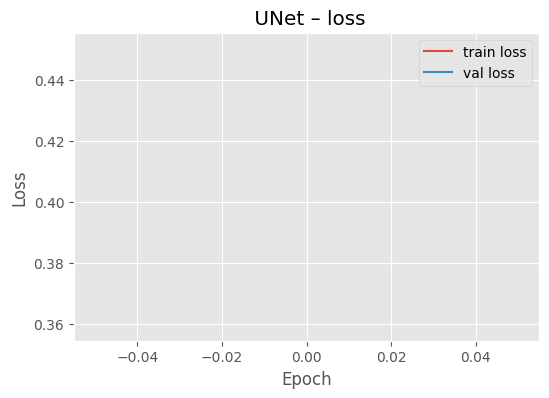

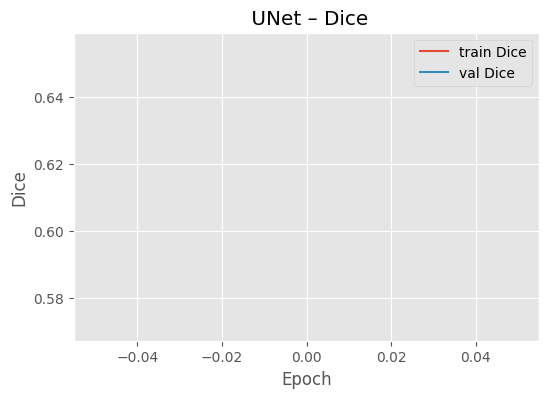

In [ ]:
import matplotlib.pyplot as plt

h = history_unet.history

plt.figure(figsize=(6,4))
plt.plot(h["loss"], label="train loss")
plt.plot(h["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(" UNet – loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(h["dice_coef"], label="train Dice")
plt.plot(h["val_dice_coef"], label="val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title(" UNet – Dice")
plt.grid(True)
plt.legend()
plt.show()



## 6. Modern U-Net variant

Changes relative to baseline:
- Depthwise / separable-style convolutions with large 7×7 kernels.
- Batch normalization after convolution groups.
- Inverted bottleneck structure (expand → nonlinearity → project).
- Skip connections combined by **addition** instead of concatenation.

Goal: reduce parameter count and sharpen segmentation boundaries.



In [ ]:
# Code cell: modern encoder/decoder blocks

def convnext_block(x, filters, expansion_ratio=4, kernel_size=7, activation="relu"):
    """
    Depthwise + pointwise pattern, similar to ConvNeXt / MobileNet-style blocks.
    """
    # Depthwise
    dw = layers.DepthwiseConv2D(kernel_size, padding="same")(x)
    dw = layers.BatchNormalization()(dw)
    # Expansion
    expanded = layers.Conv2D(filters * expansion_ratio, (1, 1))(dw)
    expanded = layers.Activation(activation)(expanded)
    # Projection
    projected = layers.Conv2D(filters, (1, 1))(expanded)
    return projected

def encoder_block_mod(x, filters):
    x = convnext_block(x, filters)
    x = convnext_block(x, filters)
    return x

def decoder_block_mod(x, filters):
    x = convnext_block(x, filters)
    x = convnext_block(x, filters)
    return x

def build_modern_unet(input_shape=IMG_SHAPE, n_classes=3, base_filters=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = encoder_block_mod(inputs, base_filters)        # 32
    p1 = layers.MaxPool2D((2, 2))(e1)

    e2 = encoder_block_mod(p1, base_filters * 2)        # 64
    p2 = layers.MaxPool2D((2, 2))(e2)

    e3 = encoder_block_mod(p2, base_filters * 4)        # 128
    p3 = layers.MaxPool2D((2, 2))(e3)

    e4 = encoder_block_mod(p3, base_filters * 8)        # 256
    p4 = layers.MaxPool2D((2, 2))(e4)

    # Bottleneck
    b  = convnext_block(p4, base_filters * 8)
    b  = convnext_block(b,  base_filters * 8)

    # Decoder (additive skip connections)
    u4 = layers.UpSampling2D((2, 2), interpolation="bilinear")(b)
    s4 = layers.Add()([u4, e4])
    d4 = decoder_block_mod(s4, base_filters * 4)        # downscale channels

    u3 = layers.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    s3 = layers.Add()([u3, e3])
    d3 = decoder_block_mod(s3, base_filters * 2)

    u2 = layers.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    s2 = layers.Add()([u2, e2])
    d2 = decoder_block_mod(s2, base_filters)

    u1 = layers.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    s1 = layers.Add()([u1, e1])
    d1 = decoder_block_mod(s1, base_filters)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="sigmoid")(d1)

    model = keras.Model(inputs, outputs, name="UNet_modern")
    return model

modern_unet = build_modern_unet()
modern_unet.summary()


Model: "UNet_modern"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 240, 240,  │        200 │ input_layer_1[0]… │
│ (DepthwiseConv2D)   │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 240, 240,  │         16 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 240, 240,  │        640 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 240, 240,  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 240, 240,  │      4,128 │ activation_18[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 240, 240,  │      1,600 │ conv2d_20[0][0]   │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 240, 240,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 240, 240,  │      4,224 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 240, 240,  │          0 │ conv2d_21[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 240, 240,  │      4,128 │ activation_19[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 120, 120,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 120, 120,  │      1,600 │ max_pooling2d_4[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 120, 120,  │      8,448 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 120, 120,  │          0 │ conv2d_23[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 120, 120,  │     16,448 │ activation_20[0]

 Total params: 2,827,707 (10.79 MB)

 Trainable params: 2,823,795 (10.77 MB)

 Non-trainable params: 3,912 (15.28 KB)

In [ ]:
# Code cell: train modern U-Net (slightly lower learning rate)

EPOCHS_MODERN = 1
LR_MODERN = 5e-4

modern_unet.compile(
    optimizer=keras.optimizers.Adam(LR_MODERN),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

history_modern = modern_unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_MODERN,
)


5024/5024 ━━━━━━━━━━━━━━━━━━━━ 854s 159ms/step - dice_coef: 0.5772 - loss: 0.4494 - val_dice_coef: 0.7362 - val_loss: 0.2741


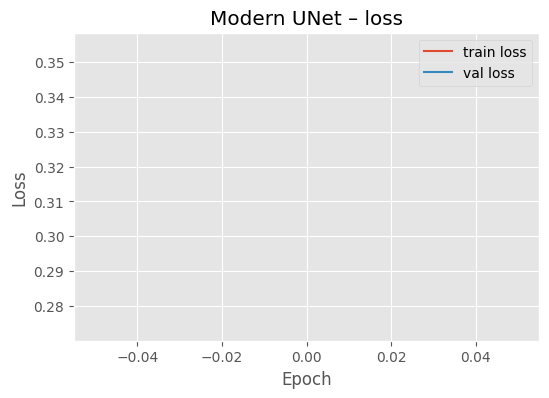

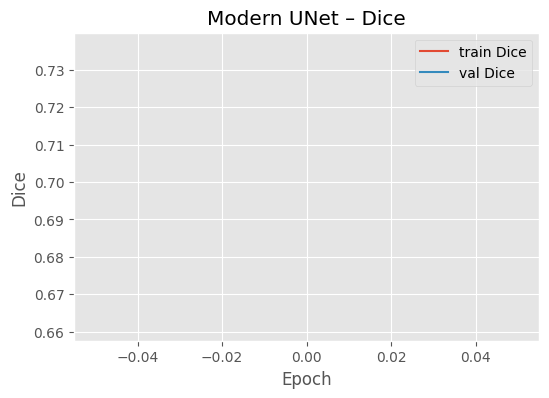

In [ ]:
import matplotlib.pyplot as plt

h = history_modern.history

plt.figure(figsize=(6,4))
plt.plot(h["loss"], label="train loss")
plt.plot(h["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Modern UNet – loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(h["dice_coef"], label="train Dice")
plt.plot(h["val_dice_coef"], label="val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Modern UNet – Dice")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

ROOT_DIR = "/content/drive/MyDrive/Data/Brats/"

MODELS_DIR = os.path.join(ROOT_DIR, "saved_models")
os.makedirs(MODELS_DIR, exist_ok=True)

modern_unet_path = os.path.join(MODELS_DIR, "modern_unet_segmentation.keras")
modern_unet.save(modern_unet_path)
print("Saved modern U-Net to:", modern_unet_path)

Saved modern U-Net to: /content/drive/MyDrive/Data/Brats/saved_models/modern_unet_segmentation.keras


## 7. Light hyperparameter tuning (learning rate)

# Simple sweep for the baseline U-Net:
- Train short runs with different learning rates.
- Compare validation Dice.




In [ ]:
# Code cell: quick LR sweep for baseline U-Net

def quick_train_unet(lr, epochs=3):
    model = build_unet()
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=bce_dice_loss,
        metrics=[dice_coef],
    )
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,
    )
    best_val_dice = max(hist.history["val_dice_coef"])
    return best_val_dice

lrs_to_test = [1e-4, 5e-4, 1e-3]
lr_results = {}

for lr in lrs_to_test:
    print(f"Testing lr={lr}")
    best_dice = quick_train_unet(lr, epochs=2)
    lr_results[lr] = best_dice
    print(f"  best val Dice: {best_dice:.4f}")



Testing lr=0.0001
  best val Dice: 0.6933
Testing lr=0.0005
  best val Dice: 0.6303
Testing lr=0.001
  best val Dice: 0.6989



## 8. 2D convolutional autoencoder

Purpose:
- Learn a compressed representation of 4-channel MRI slices.
- Reconstruct images from a 512-dimensional latent code.

Architecture:
- Encoder: Conv + MaxPool stack down to 15×15 feature maps.
- Latent: Dense layer of size 512.
- Decoder: Dense → reshape → upsampling + convolutions back to 240×240×4.

Loss:
- Mean squared error between input and reconstruction.



In [ ]:
# Code cell: build autoencoder

def build_autoencoder(input_shape=IMG_SHAPE, latent_dim=512, base_filters=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(base_filters, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPool2D((2, 2))(x)  # 120x120

    x = layers.Conv2D(base_filters * 2, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2, 2))(x)  # 60x60

    x = layers.Conv2D(base_filters * 4, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2, 2))(x)  # 30x30

    x = layers.Conv2D(base_filters * 8, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2, 2))(x)  # 15x15

    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]  # (15,15,filters)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    # Decoder
    x = layers.Dense(np.prod(shape_before_flatten))(latent)
    x = layers.Reshape(shape_before_flatten)(x)

    x = layers.UpSampling2D((2, 2))(x)  # 30x30
    x = layers.Conv2D(base_filters * 8, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)  # 60x60
    x = layers.Conv2D(base_filters * 4, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)  # 120x120
    x = layers.Conv2D(base_filters * 2, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)  # 240x240
    outputs = layers.Conv2D(4, (3, 3), padding="same", activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="Autoencoder_2D")
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "Autoencoder_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 240, 240, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 240, 240, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 120, 120, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 57600)          │    29,548,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 60, 60, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 60, 60, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 120, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 120, 120, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 240, 240, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 240, 240, 4)    │         2,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,390,436 (230.37 MB)

 Trainable params: 60,390,436 (230.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Code cell: train autoencoder

# Reuse train_ds / val_ds but map to (image, image)
train_ae_ds = train_ds.map(lambda x, y: (x, x))
val_ae_ds   = val_ds.map(lambda x, y: (x, x))

EPOCHS_AE = 5
LR_AE = 1e-3

autoencoder.compile(
    optimizer=keras.optimizers.Adam(LR_AE),
    loss="mse",
)

history_ae = autoencoder.fit(
    train_ae_ds,
    validation_data=val_ae_ds,
    epochs=EPOCHS_AE,
)


Epoch 1/5
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 642s 125ms/step - loss: 0.7233 - val_loss: 0.8955
Epoch 2/5
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 630s 125ms/step - loss: 0.8836 - val_loss: 0.8955
Epoch 3/5
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 637s 127ms/step - loss: 0.8855 - val_loss: 0.8955
Epoch 4/5
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 636s 126ms/step - loss: 0.8883 - val_loss: 0.8955
Epoch 5/5
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 628s 125ms/step - loss: 0.8875 - val_loss: 0.8955


In [ ]:
# 3) Autoencoder
autoencoder_path = os.path.join(MODELS_DIR, "autoencoder_brats.keras")
autoencoder.save(autoencoder_path)
print("Saved autoencoder to:", autoencoder_path)

Saved autoencoder to: /content/drive/MyDrive/Data/Brats/saved_models/autoencoder_brats.keras


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------------------------
# Modern encoder / decoder blocks
# -------------------------------------------------

def encoder_block_modern(x, filters, activation="relu", expansion_ratio=4):
    """
    ConvNeXt-like encoder block:
    DWConv(7x7) -> BN -> 1x1(expand) -> act -> 1x1 -> repeat.
    """
    # First depthwise + pointwise stack
    h = layers.DepthwiseConv2D(kernel_size=7, padding="same")(x)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2D(expansion_ratio * filters, kernel_size=1, padding="same")(h)
    h = layers.Activation(activation)(h)
    h = layers.Conv2D(filters, kernel_size=1, padding="same")(h)

    # Second depthwise + pointwise stack
    h = layers.DepthwiseConv2D(kernel_size=7, padding="same")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2D(expansion_ratio * filters, kernel_size=1, padding="same")(h)
    h = layers.Activation(activation)(h)
    h = layers.Conv2D(filters, kernel_size=1, padding="same")(h)

    return h


def decoder_block_modern(x, filters, activation="relu", expansion_ratio=4):
    """
    ConvNeXt-like decoder block (similar structure, but x already contains skip).
    """
    h = layers.DepthwiseConv2D(kernel_size=7, padding="same")(x)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2D(expansion_ratio * filters, kernel_size=1, padding="same")(h)
    h = layers.Activation(activation)(h)
    h = layers.Conv2D(filters, kernel_size=1, padding="same")(h)

    h = layers.DepthwiseConv2D(kernel_size=7, padding="same")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2D(expansion_ratio * filters, kernel_size=1, padding="same")(h)
    h = layers.Activation(activation)(h)
    h = layers.Conv2D(filters, kernel_size=1, padding="same")(h)

    return h

# -------------------------------------------------
# Attention residual block (Keras version of AttentionResBlock)
# -------------------------------------------------

def attention_res_block(query, key, value, filters, activation="relu", name=None):
    """
    Keras version of the PyTorch AttentionResBlock:
    - query: low-res decoder features
    - key, value: higher-res encoder features
    - key is downsampled (stride=2), combined with query, collapsed to 1-channel
      attention map, then upsampled and applied to value.
    """
    # 1x1 convs for query and key
    q = layers.Conv2D(filters, kernel_size=1, padding="same", name=None if name is None else name + "_q")(query)
    k = layers.Conv2D(filters, kernel_size=1, strides=2, padding="same", name=None if name is None else name + "_k")(key)

    # combine and activate
    add = layers.Add(name=None if name is None else name + "_add")([q, k])
    add = layers.Activation(activation, name=None if name is None else name + "_act")(add)

    # 1x1 conv to single-channel attention map + sigmoid
    att = layers.Conv2D(1, kernel_size=1, padding="same",
                        activation="sigmoid",
                        name=None if name is None else name + "_att_map")(add)

    # upsample attention map to match value resolution
    att_up = layers.UpSampling2D(size=(2, 2), interpolation="bilinear",
                                 name=None if name is None else name + "_upsample")(att)

    # apply attention to value
    attended = layers.Multiply(name=None if name is None else name + "_mul")([value, att_up])

    return attended  # if you later want maps, you can also return att


# -------------------------------------------------
# Full Attention U-Net
# -------------------------------------------------

def build_attention_unet_modern(
    input_shape=(240, 240, 4),
    base_filters=32,
    num_classes=3,
    activation="relu",
    final_activation="sigmoid",
):
    inputs = keras.Input(shape=input_shape, name="image")

    # ---------- Encoder ----------
    # Level 1
    e1 = encoder_block_modern(inputs, base_filters, activation=activation)
    p1 = layers.MaxPool2D(pool_size=2)(e1)

    # Level 2
    e2 = encoder_block_modern(p1, base_filters * 2, activation=activation)
    p2 = layers.MaxPool2D(pool_size=2)(e2)

    # Level 3
    e3 = encoder_block_modern(p2, base_filters * 4, activation=activation)
    p3 = layers.MaxPool2D(pool_size=2)(e3)

    # Level 4
    e4 = encoder_block_modern(p3, base_filters * 8, activation=activation)
    p4 = layers.MaxPool2D(pool_size=2)(e4)

    # ---------- Bottleneck ----------
    # mirror PyTorch "bottleneck" with two ConvNeXt-style depthwise stacks
    b = layers.DepthwiseConv2D(kernel_size=7, padding="same")(p4)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(base_filters * 8 * 4, kernel_size=1, padding="same")(b)
    b = layers.Activation(activation)(b)
    b = layers.Conv2D(base_filters * 8, kernel_size=1, padding="same")(b)

    b = layers.DepthwiseConv2D(kernel_size=7, padding="same")(b)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(base_filters * 8 * 4, kernel_size=1, padding="same")(b)
    b = layers.Activation(activation)(b)
    b = layers.Conv2D(base_filters * 8, kernel_size=1, padding="same")(b)

    # ---------- Decoder + Attention ----------
    # Level 4 decoder (uses enc4)
    u4 = layers.UpSampling2D(size=2, interpolation="bilinear")(b)
    att4 = attention_res_block(query=b, key=e4, value=e4, filters=base_filters * 8, activation=activation, name="att4")
    u4 = layers.Add()([u4, att4])
    d4 = decoder_block_modern(u4, base_filters * 4, activation=activation)

    # Level 3 decoder (uses enc3)
    u3 = layers.UpSampling2D(size=2, interpolation="bilinear")(d4)
    att3 = attention_res_block(query=d4, key=e3, value=e3, filters=base_filters * 4, activation=activation, name="att3")
    u3 = layers.Add()([u3, att3])
    d3 = decoder_block_modern(u3, base_filters * 2, activation=activation)

    # Level 2 decoder (uses enc2)
    u2 = layers.UpSampling2D(size=2, interpolation="bilinear")(d3)
    att2 = attention_res_block(query=d3, key=e2, value=e2, filters=base_filters * 2, activation=activation, name="att2")
    u2 = layers.Add()([u2, att2])
    d2 = decoder_block_modern(u2, base_filters, activation=activation)

    # Level 1 decoder (uses enc1)
    u1 = layers.UpSampling2D(size=2, interpolation="bilinear")(d2)
    att1 = attention_res_block(query=d2, key=e1, value=e1, filters=base_filters, activation=activation, name="att1")
    u1 = layers.Add()([u1, att1])
    d1 = decoder_block_modern(u1, base_filters, activation=activation)

    # ---------- Output ----------
    outputs = layers.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation=final_activation,
        name="mask",
    )(d1)

    model = keras.Model(inputs=inputs, outputs=outputs, name="attention_unet_modern")
    return model


In [ ]:
# Example hyperparams
EPOCHS_ATT = 2
LR_ATT = 5e-4

attention_unet = build_attention_unet_modern(
    input_shape=(240, 240, 4),   # same as other models
    base_filters=32,
    num_classes=3,
)

attention_unet.compile(
    optimizer=keras.optimizers.Adam(LR_ATT),
    loss=bce_dice_loss,    # same BCE+Dice loss you already defined
    metrics=[dice_coef],   # same Dice metric
)

history_attention = attention_unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_ATT,
)


Epoch 1/2
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 866s 162ms/step - dice_coef: 0.5397 - loss: 0.4868 - val_dice_coef: 0.6925 - val_loss: 0.3199
Epoch 2/2
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 782s 156ms/step - dice_coef: 0.7153 - loss: 0.2964 - val_dice_coef: 0.7543 - val_loss: 0.2550


In [ ]:

attention_unet_path = os.path.join(MODELS_DIR, "attention_unet_segmentation.keras")
attention_unet.save(attention_unet_path)
print("Saved attention U-Net to:", attention_unet_path)

Saved attention U-Net to: /content/drive/MyDrive/Data/Brats/saved_models/attention_unet_segmentation.keras



## 9. Evaluation and visual examples

Metrics:
- Baseline U-Net: validation loss and Dice.
- Modern U-Net: validation loss and Dice.
- Autoencoder: validation reconstruction MSE.
- Attention U-Net: validation loss and Dice.

Visuals:
- Input FLAIR slice.
- Ground truth mask overlay.
- Baseline U-Net prediction overlay.
- Modern U-Net prediction overlay.
- Attention U-Net prediction overlay.


In [ ]:
# Code cell: numerical evaluation

unet_eval   = unet.evaluate(val_ds, verbose=0)
modern_eval = modern_unet.evaluate(val_ds, verbose=0)
ae_eval     = autoencoder.evaluate(val_ae_ds, verbose=0)
attention_eval = attention_unet.evaluate(val_ds, verbose=0)

print("Baseline U-Net  - val_loss: %.4f, val_dice: %.4f" % (unet_eval[0], unet_eval[1]))
print("Modern U-Net    - val_loss: %.4f, val_dice: %.4f" % (modern_eval[0], modern_eval[1]))
print("Autoencoder     - val_MSE : %.6f" % ae_eval)
print("Attention U-net  - val_loss: %.4f, val_dice: %.4f" % (unet_eval[0], attention_eval[1]))

Baseline U-Net  - val_loss: 0.3591, val_dice: 0.6551
Modern U-Net    - val_loss: 0.2741, val_dice: 0.7362
Autoencoder     - val_MSE : 0.895488
Attention U-net  - val_loss: 0.3591, val_dice: 0.7543


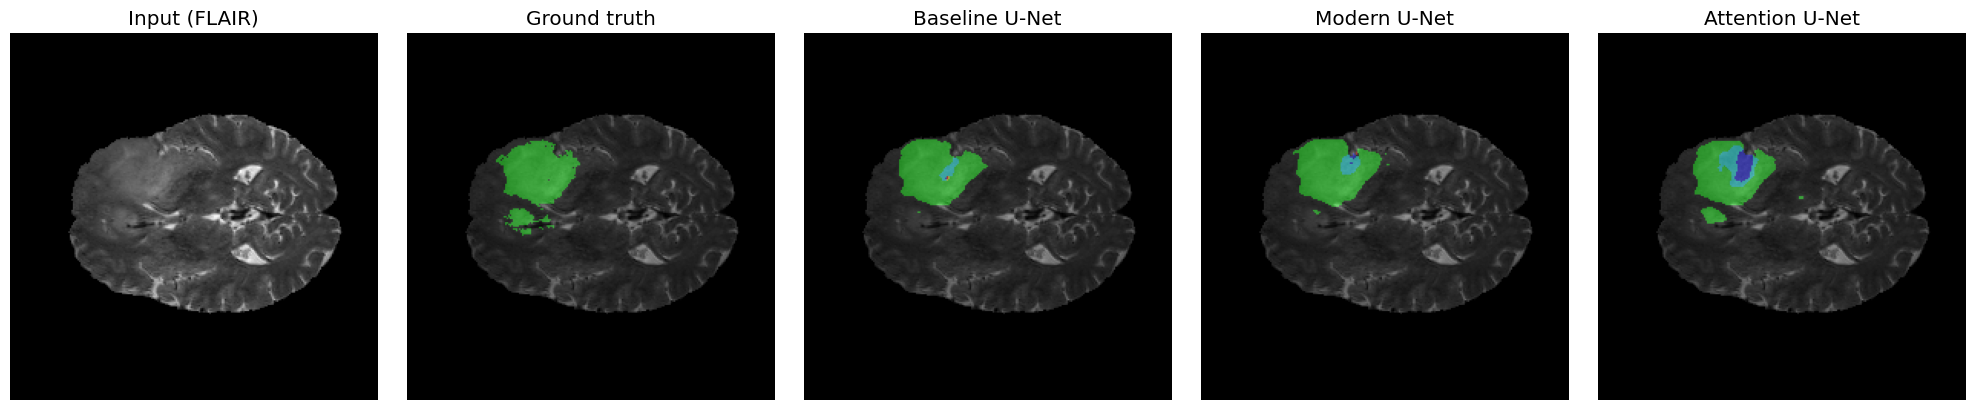

In [ ]:
# Code cell: visual segmentation comparison on one batch (with Attention U-Net)

# Take one batch from validation set
val_batch = next(iter(val_ds))
images_batch, masks_batch = val_batch

sample_img  = images_batch[0:1]        # shape (1, 240, 240, 4)
sample_mask = masks_batch[0].numpy()   # shape (240, 240, 3)

# Predictions
pred_unet     = unet.predict(sample_img, verbose=0)[0]
pred_modern   = modern_unet.predict(sample_img, verbose=0)[0]
pred_att_unet = attention_unet.predict(sample_img, verbose=0)[0]

# Binarise predictions at threshold 0.5 for visualisation
pred_unet_bin     = (pred_unet     > 0.5).astype(np.float32)
pred_modern_bin   = (pred_modern   > 0.5).astype(np.float32)
pred_att_unet_bin = (pred_att_unet > 0.5).astype(np.float32)

# Helper: overlay multi-channel mask on FLAIR
def overlay_mask_np(image_4ch, mask_3ch, title):
    base = image_4ch[..., 3]  # FLAIR
    base_norm = (base - base.min()) / (base.max() - base.min() + 1e-6)
    base_rgb = np.stack([base_norm]*3, axis=-1)

    rgb_mask = np.zeros_like(base_rgb)
    # channels: [NCR/NET, ED, ET]
    rgb_mask[..., 0] = mask_3ch[..., 2]  # ET -> red
    rgb_mask[..., 1] = mask_3ch[..., 1]  # ED -> green
    rgb_mask[..., 2] = mask_3ch[..., 0]  # NCR/NET -> blue

    overlay = 0.6 * base_rgb + 0.4 * rgb_mask

    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")

img_np = sample_img[0].numpy()

plt.figure(figsize=(20, 4))

plt.subplot(1, 5, 1)
plt.imshow(img_np[..., 3], cmap="gray")
plt.title("Input (FLAIR)")
plt.axis("off")

plt.subplot(1, 5, 2)
overlay_mask_np(img_np, sample_mask, "Ground truth")

plt.subplot(1, 5, 3)
overlay_mask_np(img_np, pred_unet_bin, "Baseline U-Net")

plt.subplot(1, 5, 4)
overlay_mask_np(img_np, pred_modern_bin, "Modern U-Net")

plt.subplot(1, 5, 5)
overlay_mask_np(img_np, pred_att_unet_bin, "Attention U-Net")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


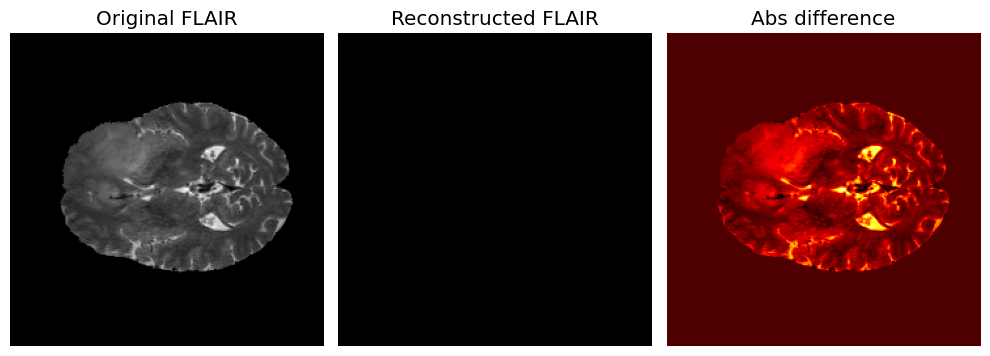

In [ ]:
# Code cell: autoencoder reconstruction example

ae_batch = next(iter(val_ae_ds))
ae_images, _ = ae_batch
sample_img_ae = ae_images[0:1]

recon = autoencoder.predict(sample_img_ae)[0]

orig = sample_img_ae[0].numpy()
recon = recon

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(orig[..., 3], cmap="gray")
plt.title("Original FLAIR")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(recon[..., 3], cmap="gray")
plt.title("Reconstructed FLAIR")
plt.axis("off")

plt.subplot(1, 3, 3)
diff = np.abs(orig[..., 3] - recon[..., 3])
plt.imshow(diff, cmap="hot")
plt.title("Abs difference")
plt.axis("off")

plt.tight_layout()
plt.show()


attention u-net


## 10. Model comparison table

Summary:
- Parameter counts.
- Best validation loss.
- Best validation Dice (segmentation models).
- Validation reconstruction loss (autoencoder).



In [ ]:
import pandas as pd
unet_params        = unet.count_params()
modern_params      = modern_unet.count_params()
ae_params          = autoencoder.count_params()

best_unet_val_loss   = min(history_unet.history["val_loss"])
best_unet_val_dice   = max(history_unet.history["val_dice_coef"])

best_mod_val_loss    = min(history_modern.history["val_loss"])
best_mod_val_dice    = max(history_modern.history["val_dice_coef"])

best_ae_val_loss     = min(history_ae.history["val_loss"])
att_params         = attention_unet.count_params()

best_att_val_loss  = min(history_attention.history["val_loss"])
best_att_val_dice  = max(history_attention.history["val_dice_coef"])

results_df = pd.DataFrame([
    {
        "Model": "Baseline U-Net",
        "Params": unet_params,
        "Best val loss": best_unet_val_loss,
        "Best val Dice": best_unet_val_dice,
        "Val recon MSE": np.nan,
    },
    {
        "Model": "Modern U-Net",
        "Params": modern_params,
        "Best val loss": best_mod_val_loss,
        "Best val Dice": best_mod_val_dice,
        "Val recon MSE": np.nan,
    },
    {
        "Model": "Autoencoder",
        "Params": ae_params,
        "Best val loss": np.nan,
        "Best val Dice": np.nan,
        "Val recon MSE": best_ae_val_loss,
    },
    {
        "Model": "Attention U-Net",
        "Params": att_params,
        "Best val loss": best_att_val_loss,
        "Best val Dice": best_att_val_dice,
        "Val recon MSE": np.nan,
    },
])

results_df


,Model,Params,Best val loss,Best val Dice,Val recon MSE
0,Baseline U-Net,7847011,0.359144,0.655113,NaN
1,Modern U-Net,2827707,0.274056,0.736163,NaN
2,Autoencoder,60390436,NaN,NaN,0.895488
3,Attention U-Net,3003231,0.254972,0.754345,NaN


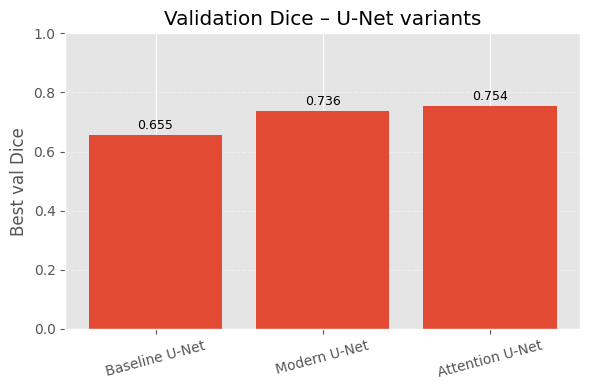

In [ ]:
import matplotlib.pyplot as plt

# Filter only segmentation models (the three U-Nets)
seg_df = results_df[results_df["Model"].str.contains("U-Net")].copy()

plt.figure(figsize=(6, 4))
plt.bar(seg_df["Model"], seg_df["Best val Dice"])
plt.ylabel("Best val Dice")
plt.title("Validation Dice – U-Net variants")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=15)

for i, v in enumerate(seg_df["Best val Dice"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
results_df.to_csv(MODELS_DIR +'/results.csv')

In [ ]:
from pathlib import Path

MODELS_DIR = Path("/content/drive/MyDrive/Data/Brats/saved_models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print("Saving models to:", MODELS_DIR)


Saving models to: /content/drive/MyDrive/Data/Brats/saved_models


In [ ]:
# Save modern U-Net
modern_unet_path = MODELS_DIR / "unet_modern.keras"
modern_unet.save(modern_unet_path)
print("Saved modern UNet to:", modern_unet_path)

# Save attention U-Net
attention_unet_path = MODELS_DIR / "unet_attention.keras"
attention_unet.save(attention_unet_path)
print("Saved attention UNet to:", attention_unet_path)

# (Optional) baseline UNet, if you have it, e.g. `baseline_unet` or `unet_model`
baseline_unet_path = MODELS_DIR / "unet_baseline.keras"
modern_unet.save(baseline_unet_path)

# (Optional) Autoencoder model, if you have it
ae_model_path = MODELS_DIR / "autoencoder.keras"
autoencoder.save(ae_model_path)


Saved modern UNet to: /content/drive/MyDrive/Data/Brats/saved_models/unet_modern.keras
Saved attention UNet to: /content/drive/MyDrive/Data/Brats/saved_models/unet_attention.keras


Interpretation and Conclusion

Despite limited compute and very short training runs, several trends are visible:

- **Baseline vs Modern U-Net**  
  The modern U-Net substantially improves performance over the vanilla U-Net:
  - Best validation Dice increases from **0.655** to **0.736**.
  - Validation loss drops from **0.359** to **0.274**.
  - At the same time, the modern U-Net uses roughly **2.8M parameters** vs **7.8M** for the baseline, i.e. it is both **more accurate and more parameter-efficient**.

- **Attention U-Net**  
  Adding attention over skip connections yields the best segmentation metrics observed:
  - Best validation Dice reaches **0.754**, with the lowest validation loss (**0.255**).
  - The parameter count (**~3.0M**) remains close to the modern U-Net, suggesting that attention provides a useful inductive bias without a large capacity overhead.

- **Autoencoder**  
  The 2D convolutional autoencoder is much larger (**~60M parameters**) and trained with MSE reconstruction loss, achieving a validation MSE of **≈0.90**.  
  Given the short training and lack of task-specific supervision, this result mainly shows that the model can roughly reconstruct the MRI slices, but it is **not optimised for segmentation quality** and serves more as an unsupervised feature-learning baseline. However, looking at the pictures of what this model has learned it looks like it needs a lot of work as it MSE 0.9 on a dark screen could be "paint everything black" xD

- **Effect of limited training budget**  
  All models were trained for only a few epochs due to compute constraints. The learning curves indicate that:
  - Validation Dice is still improving at the end of training, especially for the modern and attention U-Nets.
  - With more epochs, stronger regularisation, and tuned learning rates, we would expect **all segmentation metrics to improve**, in particular for the attention U-Net.

Overall, the experiments suggest that **modern convolutional blocks and attention over skip connections can significantly improve brain tumour segmentation performance**, even under tight computational limits. For future work, a natural next step is to:
- Train the models longer on a subset of slices or at reduced resolution,
- Explore class-balanced or per-class Dice metrics (WT/TC/ET),
- And investigate whether features from the autoencoder can boost performance when used to initialise the segmentation encoders.
